# Quantum Teleportation Protocol

## Teleporting a single qubit - Simulation

In [67]:
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import transpile
from qiskit.result import Counts, marginal_counts
from qiskit.visualization import array_to_latex, plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator

In [68]:
def create_random_data_qubit(dimensions: int) -> Statevector:
    return random_statevector(dimensions)

In [69]:
def create_bell_pair(qc: QuantumCircuit, a: QuantumRegister, b: QuantumRegister) -> None:
    qc.barrier()
    qc.h(a)
    qc.cx(a, b)

In [70]:
def bell_state_operation(qc: QuantumCircuit, d: QuantumRegister, a: QuantumRegister) -> None:
    qc.barrier()
    qc.cx(d, a)
    qc.h(d)

In [71]:
def bell_state_measurement(qc: QuantumCircuit, a: QuantumRegister, b: QuantumRegister) -> None:
    qc.barrier()
    qc.measure(a, 0)
    qc.measure(b, 1)

In [72]:
def pauli_correction_operation(qc: QuantumCircuit, b: QuantumRegister, crz: ClassicalRegister, crx: ClassicalRegister) -> None:
    # Apply the gates if the registers are in the state '1'
    qc.barrier()
    qc.x(b).c_if(crx, 1)
    qc.z(b).c_if(crz, 1)

In [73]:
def statevector_simulation(qc: QuantumCircuit) -> Statevector:
    statevector_sim: StatevectorSimulator = StatevectorSimulator()
    # qc.save_statevector()
    return statevector_sim.run(qc).result().get_statevector()

In [74]:
def qasm_count_simulation(qc: QuantumCircuit) -> Counts:
    qasm_sim: QasmSimulator = QasmSimulator()
    t_qc = transpile(qc, qasm_sim)
    # t_qc.save_statevector()
    return qasm_sim.run(t_qc).result().get_counts()

#### Initialize registers, qubits and quantumm circuit

In [75]:
data: QuantumRegister = QuantumRegister(1, "data")

alice: QuantumRegister = QuantumRegister(1, "alice")
bob: QuantumRegister = QuantumRegister(1, "bob")

crz: ClassicalRegister = ClassicalRegister(1, "crz")
crx: ClassicalRegister = ClassicalRegister(1, "crx")

coz: ClassicalRegister = ClassicalRegister(1, "coz")

qc: QuantumCircuit = QuantumCircuit(data, alice, bob, crz, crx, coz)

#### Initialize Alice's data qubit

<IPython.core.display.Latex object>

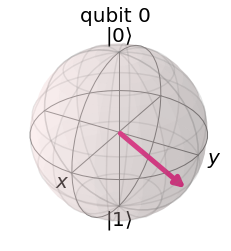

In [76]:
psi: Statevector = create_random_data_qubit(2)
display(array_to_latex(psi, prefix="|\\psi\\rangle = "))
plot_bloch_multivector(psi)

In [77]:
init_instruction: Initialize = Initialize(psi)
init_instruction.label = "init instruction"

qc.append(init_instruction, data)

#### Create a Bell Pair

A third party, Telemon/Charlie creates the Bell pair to distribute to Bob and Alice.

In [78]:
create_bell_pair(qc, alice, bob)

#### Bell State Measurement Operation

In [79]:
bell_state_operation(qc, data, alice)

#### Operations after a Bell State Measurement

00 -> Do nothing

01 -> Apply X-gate

10 -> Apply Z-gate

11 -> Apply ZX gates

In [80]:
bell_state_measurement(qc, data, alice)

#### Pauli correction operation

After BSM, results are stored in two classical bits and send to Bob for Bob to complete teleportation

In [81]:
pauli_correction_operation(qc, bob, crz, crx)

#### Statevector Simulator

We use a simulated statevector to __verify__ teleportation of our qubit

Observe that the state of initial qubit data and final qubit Bob are same. The data qubit was teleported to Bob.

In [82]:
vector_state = statevector_simulation(qc)
array_to_latex(vector_state)

<IPython.core.display.Latex object>

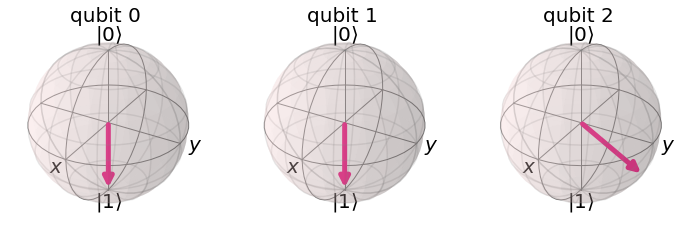

In [83]:
plot_bloch_multivector(vector_state)

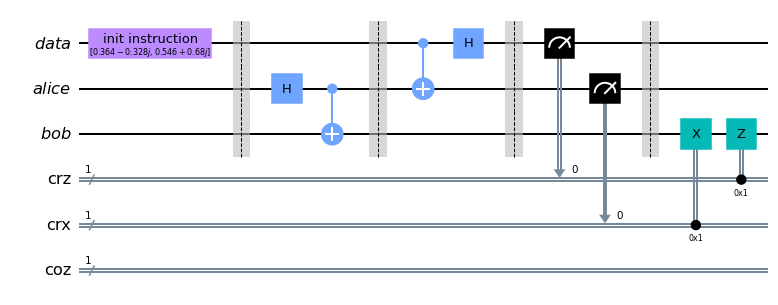

In [84]:
qc.draw("mpl")

#### Qasm Simulator

__Verify__ and __demonstrate__ that the gates perform the correct transformations.

All gates are reversible and we can find the inverse of said gates

#### Create inverse initialization gate

In [85]:
inverse_init_instruction: Initialize = init_instruction.gates_to_uncompute()

#### Apply inverse intialization instruction

In [86]:
qc.barrier()
qc.append(inverse_init_instruction, bob)

#### Bob's measurement

Make measurement on Bob's qubit

In [87]:
qc.barrier()
qc.measure(bob, coz)

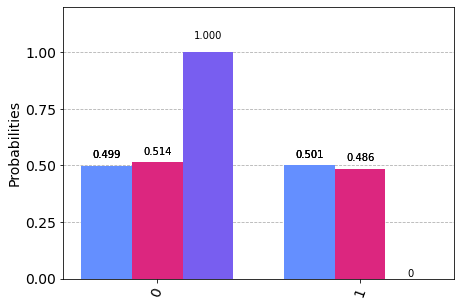

In [88]:
counts = qasm_count_simulation(qc)
qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(3)]
# print(type(counts), "\n", type(qubit_counts))
# print(counts, qubit_counts)
plot_histogram(qubit_counts)

#### Confirmation



The above results indicate that we have 100% chance measureing Bob's qubit in state  $|0\rangle$ as is expected. Teleportation protocol is working as expected.

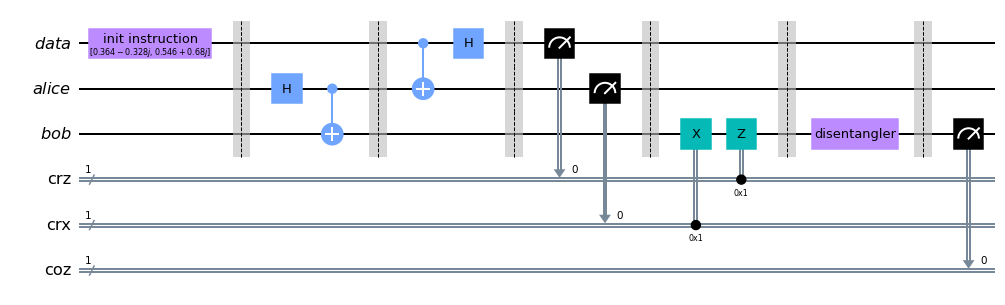

In [89]:
qc.draw("mpl")